# **Abstract**

This paper aims to equip intrusion analysts with the basic techniques needed to apply machine learning to intrusion detection. It will first describe the different approaches to machine learning-based classification (e.g., logistic regression, support vector machines), so readers will gain some basic understanding of underlying algorithms that will be useful during model selection and parameter adjustment. It will also describe methods of data preprocessing, model training and testing.

This paper then describes experiments carried out on a dataset (NSL-KDD) which is widely used for the testing of intrusion detection algorithms. Two sets of experiments are carried out 1) application of commonly-used machine learning based classification models and 2) application of methods widely-used to improve model performance (e.g., boosting, bagging, stacking, and automatic learning of features).

# **Introduction**

With brief desciptions of key machine learning models and sample code illustrating how they can be applied to network data, this paper aims to equip intrusion analysts

In [ ]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Concatenate, Lambda, GaussianNoise, Activation, Embedding, concatenate, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupKFold

# processing imports
# module imports
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

# model imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# processing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

In [ ]:
from sklearn import linear_model

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import IsolationForest

from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [ ]:
SPLIT = 0

In [ ]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.4.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# edit to fetch your data
file_path_20_percent = '/content/drive/My Drive/KDDTrain+_20Percent.txt'
file_path_full_training_set = '/content/drive/My Drive/KDDTrain+.txt'
file_path_test = '/content/drive/My Drive/KDDTest+.txt' 

train_all = pd.read_csv(file_path_full_training_set)
test_all = pd.read_csv(file_path_test)

In [ ]:
# add the column labels
columns = (['duration'
,'protocol_type'
,'service'
,'flag'
,'src_bytes'
,'dst_bytes'
,'land'
,'wrong_fragment'
,'urgent'
,'hot'
,'num_failed_logins'
,'logged_in'
,'num_compromised'
,'root_shell'
,'su_attempted'
,'num_root'
,'num_file_creations'
,'num_shells'
,'num_access_files'
,'num_outbound_cmds'
,'is_host_login'
,'is_guest_login'
,'count'
,'srv_count'
,'serror_rate'
,'srv_serror_rate'
,'rerror_rate'
,'srv_rerror_rate'
,'same_srv_rate'
,'diff_srv_rate'
,'srv_diff_host_rate'
,'dst_host_count'
,'dst_host_srv_count'
,'dst_host_same_srv_rate'
,'dst_host_diff_srv_rate'
,'dst_host_same_src_port_rate'
,'dst_host_srv_diff_host_rate'
,'dst_host_serror_rate'
,'dst_host_srv_serror_rate'
,'dst_host_rerror_rate'
,'dst_host_srv_rerror_rate'
,'attack'
,'level'])

train_all.columns = columns
test_all.columns = columns

# sanity check
train_all.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [ ]:
# map normal to 0, all attacks to 1
train_all['attack_flag'] = train_all.attack.apply(lambda a: 0 if a == 'normal' else 1)
test_all['attack_flag'] = test_all.attack.apply(lambda a: 0 if a == 'normal' else 1)

In [ ]:
#cat and num features
features_to_encode = ['protocol_type', 'service', 'flag']
numeric_features = ['duration', 'src_bytes', 'dst_bytes']

In [ ]:
# 1 hot encoding
encoded = pd.get_dummies(train_all[features_to_encode])
test_encoded_base = pd.get_dummies(test_all[features_to_encode])

# not all of the features are in the test set, so we need to account for diffs
test_index = np.arange(len(test_all.index))
column_diffs = list(set(encoded.columns.values)-set(test_encoded_base.columns.values))

diff_df = pd.DataFrame(0, index=test_index, columns=column_diffs)

#get column order for matching later
column_order = encoded.columns.to_list()

# append the new columns
test_encoded_temp = test_encoded_base.join(diff_df)

# reorder the columns
test_final = test_encoded_temp[column_order]

test_final = test_final.fillna(0)

# model to fit/test
train_1hot = encoded.join(train_all[numeric_features])
test_1hot = test_final.join(test_all[numeric_features])

In [ ]:
train_lab = train_all[features_to_encode + numeric_features]
test_lab = test_all[features_to_encode + numeric_features]

In [ ]:
max_values = {}
for col in features_to_encode:
  print(col)
  lbl = LabelEncoder()
  lbl.fit(list(train_lab[col].values.astype('str')) + list(test_lab[col].values.astype('str')))
  train_lab[col] = lbl.transform(list(train_lab[col].values.astype('str')))
  test_lab[col] = lbl.transform(list(test_lab[col].values.astype('str')))
  max_values[col] = max(train_lab[col].max(), test_lab[col].max())  + 2

protocol_type


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


service
flag


In [ ]:
train_all_features = pd.concat([train_1hot, train_lab[["protocol_type", "service", "flag"]]], axis = 1)

In [ ]:
train_all_features

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,...,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,protocol_type,service,flag
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,146,0,2,44,9
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,49,5
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,232,8153,1,24,9
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,199,420,1,24,9
4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,49,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125967,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,49,5
125968,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,8,105,145,2,49,9
125969,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2231,384,1,54,9
125970,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,30,5


In [ ]:
# create our target classifications
binary_y = train_all['attack_flag']

test_binary_y = test_all['attack_flag']

if SPLIT == 1:
  binary_train_X, binary_val_X, binary_train_y, binary_val_y = train_test_split(train_all_features, binary_y, test_size=0.2, random_state=10)
  train_X_lab = binary_train_X[features_to_encode + numeric_features]
  train_X_1hot = binary_train_X.drop(columns=features_to_encode)
else:
  train_X_lab = train_all_features[features_to_encode + numeric_features]
  train_X_1hot = train_all_features.drop(columns=features_to_encode)

# **Naive Bayesian**

Naive Bayes classifiers apply Bayes' theorem, assuming independence between features.

In [ ]:
from sklearn.naive_bayes import GaussianNB
# model for the binary classification
NB_pipe = make_pipeline(StandardScaler(), GaussianNB())

NB_pipe.fit(train_X_lab, binary_y)

# model for the binary classification
full_predictions_NB = NB_pipe.predict(test_lab)

# get the score
full_score_NB = accuracy_score(full_predictions_NB, test_binary_y)
full_score_NB

0.601250942642949

# **Logistic Regression**

Logistic regression is commonly used to estimate the probability that a test sample belongs to a particular class.

### Logistic regression: regression and a sigmoid

Logistic regression applies a sigmoid function to the output of the linear regression.

Regression:
$$z = \theta_0 x_0 + \theta_1 x_1 + \theta_2 x_2 + ... \theta_N x_N$$

Logistic regression
$$ h(z) = \frac{1}{1+\exp^{-z}}$$

### Cost function

The cost function used for logistic regression is the average of the log loss across all training examples:

$$J(\theta) = -\frac{1}{m} \sum_{i=1}^m y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) $$
* $m$ is the number of training examples
* $y^{(i)}$ is the actual label of the i-th training example.
* $h(z(\theta)^{(i)})$ is the model's prediction for the i-th training example.

The loss function for a single training example is
$$ Loss = -\left( y^{(i)}\log (h(z(\theta)^{(i)})) + (1-y^{(i)})\log (1-h(z(\theta)^{(i)})) \right)$$

When the model makes a correct prediction for a training sample, the loss is close to 0. Otherwise, the loss is close to 1.


In [ ]:
# model for the binary classification
logreg_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=250))

logreg_pipe.fit(train_X_lab, binary_y)

# model for the binary classification
full_predictions_logreg = logreg_pipe.predict(test_lab)

# get the score
full_score_logreg = accuracy_score(full_predictions_logreg, test_binary_y)
full_score_logreg

0.785920241316595

# **Support Vector Machines**

The training of support vector machines involves finding the optimal hyperplane for two linearly separable classes of training samples. Support vectors are the training samples that lie closest to the decision hyperplane, i.e., the optimal hyperplane will change if any of them is removed. SVMs maximise the margin between support vectors of different classes.

Kernel trick

Adding polynomial features can improve performance of SVMs. However, the increase in features also increases complexity of model training. Fortunately, a trick can be applied when using SVM to achieve the same result of adding many high-degree polynomial features, without actually having to add them and incurring the complexity cost. 




In [ ]:
# model for the binary classification
svm_pipe = make_pipeline(StandardScaler(), SVC(C=0.001, kernel="rbf", gamma=5, probability=True))
svm_pipe.fit(train_X_lab, binary_y)
full_svm_prediction = svm_pipe.predict(test_lab)

In [ ]:
full_svm_model_score = accuracy_score(full_svm_prediction, test_binary_y)
full_svm_model_score

0.7967440003548774

# **Ensemble Learning**

Ensemble learning techniques combine the decisions from multiple models to improve overall performance. Often, simply averaging the output of several simple models can lead to performance improvement.


In [ ]:
#simple averaging
weighted = logreg_pipe.predict_proba(test_lab)[:,1]*0.5 + svm_pipe.predict_proba(test_lab)[:,1]*0.5
weighted_bi =  np.where(weighted >= 0.5, 1, 0).astype(int)
weighted_score = accuracy_score(weighted_bi, test_binary_y)
weighted_score

0.806281329015659

## Stacking

The previous example showed how aggregating the results of classifiers with simple functions (e.g., by averaging) can lead an improvement of overall performance. Stacking is a simple extension of this idea: aggregation of classification output is performed by a model. To achieve this, a common approach is to split the training set into two subsets. The first subset is used to train individual classifiers while the second subset is used to train the model to aggregate the output from individual classifiers.

In [ ]:
train_X_sub1, train_X_sub2, train_y_sub1, train_y_sub2 = train_test_split(train_X_lab, binary_y, test_size=0.5, random_state=10)

In [ ]:
# model for the binary classification
logreg_pipe_sub1 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=250))
logreg_pipe_sub1.fit(train_X_sub1, train_y_sub1)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=250,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [ ]:
# model for the binary classification
logreg_pipe_sub1 = make_pipeline(StandardScaler(), LogisticRegression(max_iter=250))
logreg_pipe_sub1.fit(train_X_sub1, train_y_sub1)

# model for the binary classification
predictions_logreg_sub2 = logreg_pipe_sub1.predict(train_X_sub2)

# get the score
score_logreg_sub2 = accuracy_score(predictions_logreg_sub2, train_y_sub2)
score_logreg_sub2

0.9201886133426476

In [ ]:
# model for the binary classification
svm_pipe_sub1 = make_pipeline(StandardScaler(), SVC(C=0.001, kernel="rbf", gamma=5, probability=True))
svm_pipe_sub1.fit(train_X_sub1, train_y_sub1)

# model for the binary classification
predictions_svm_sub2 = svm_pipe_sub1.predict(train_X_sub2)

# get the score
score_svm_sub2 = accuracy_score(predictions_svm_sub2, train_y_sub2)
score_svm_sub2

0.9244117740450258

In [ ]:
print(accuracy_score(logreg_pipe_sub1.predict(test_lab), test_binary_y))
print(precision_score(logreg_pipe_sub1.predict(test_lab), test_binary_y))
print(recall_score(logreg_pipe_sub1.predict(test_lab), test_binary_y))
print(f1_score(logreg_pipe_sub1.predict(test_lab), test_binary_y))

0.785920241316595
0.6386377805486284
0.9774570610687023
0.7725301659125188


In [ ]:
print(accuracy_score(svm_pipe_sub1.predict(test_lab), test_binary_y))
print(precision_score(svm_pipe_sub1.predict(test_lab), test_binary_y))
print(recall_score(svm_pipe_sub1.predict(test_lab), test_binary_y))
print(f1_score(svm_pipe_sub1.predict(test_lab), test_binary_y))

0.8020228008694495
0.737998753117207
0.8958471289376596
0.8092979532538563


In [ ]:
#simple averaging
weighted = logreg_pipe_sub1.predict_proba(test_lab)[:,1]*0.5 + svm_pipe_sub1.predict_proba(test_lab)[:,1]*0.5
weighted_bi =  np.where(weighted >= 0.5, 1, 0).astype(int)
print(accuracy_score(weighted_bi, test_binary_y))
print(precision_score(weighted_bi, test_binary_y))
print(recall_score(weighted_bi, test_binary_y))
print(f1_score(weighted_bi, test_binary_y))

0.8058377323337621
0.6749532418952618
0.9767677906845608
0.798285635282732


In [ ]:
#stacking
stack_train_LR = pd.DataFrame(logreg_pipe_sub1.predict_proba(train_X_sub2)[:,1])
stack_train_SVM = pd.DataFrame(svm_pipe_sub1.predict_proba(train_X_sub2)[:,1])
stack_train_LR_SVM = pd.concat([stack_train_LR, stack_train_SVM], axis = 1)

In [ ]:
full_predictions_logreg_proba = logreg_pipe_sub1.predict_proba(test_lab)[:,1]
full_prediction_svm_proba = svm_pipe_sub1.predict_proba(test_lab)[:,1]

In [ ]:
# model for the binary classification
logreg_stack_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=250))

logreg_stack_pipe.fit(stack_train_LR_SVM, train_y_sub2)

stack_test_LR = pd.DataFrame(full_predictions_logreg_proba)
stack_test_SVM = pd.DataFrame(full_prediction_svm_proba)

stack_test = pd.concat([stack_test_LR, stack_test_SVM], axis = 1)

# model for the binary classification
full_predictions_stack_logreg = logreg_stack_pipe.predict(stack_test)

full_predictions_stack_logreg =  np.where(full_predictions_stack_logreg >= 0.5, 1, 0).astype(int)
# get the score
full_score_stack_logreg = accuracy_score(full_predictions_stack_logreg, test_binary_y)
full_score_stack_logreg

0.7956350086501353

In [ ]:
print(accuracy_score(full_predictions_stack_logreg, test_binary_y))
print(precision_score(full_predictions_stack_logreg, test_binary_y))
print(recall_score(full_predictions_stack_logreg, test_binary_y))
print(f1_score(full_predictions_stack_logreg, test_binary_y))

0.7956350086501353
0.7210099750623441
0.9000875571553653
0.8006576954696898


In [ ]:
# model for the binary classification
RF_stack = RandomForestClassifier(n_estimators=10, criterion='entropy', max_features='auto', bootstrap=True, random_state=10)

RF_stack.fit(stack_train_LR_SVM, train_y_sub2)

stack_test_LR = pd.DataFrame(full_predictions_logreg_proba)
stack_test_SVM = pd.DataFrame(full_prediction_svm_proba)

stack_test = pd.concat([stack_test_LR, stack_test_SVM], axis = 1)

# model for the binary classificationstack_test
full_predictions_stack_RF = RF_stack.predict(stack_test)

# get the score
full_score_stack_RF = accuracy_score(full_predictions_stack_RF, test_binary_y)
full_score_stack_RF

0.8124916825622145

In [ ]:
print(accuracy_score(full_predictions_stack_RF, test_binary_y))
print(precision_score(full_predictions_stack_RF, test_binary_y))
print(recall_score(full_predictions_stack_RF, test_binary_y))
print(f1_score(full_predictions_stack_RF, test_binary_y))

0.8124916825622145
0.7353491271820449
0.9190610694457972
0.8170050651543357


## Bagging

Another approach to get a diverse set of classifiers is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. This method is called bootstrap aggregating (bagging).

In [ ]:
RF = RandomForestClassifier(n_estimators=10, criterion='entropy', max_features='auto', bootstrap=True, random_state=10)
RF.fit(train_X_lab, binary_y)
RF_feature = RF.feature_importances_
#RF_feature

full_RF_prediction = RF.predict(test_lab)
full_score_RF = accuracy_score(full_RF_prediction, test_binary_y)

full_score_RF

0.8187463957769596

In [ ]:
print(accuracy_score(full_RF_prediction, test_binary_y))
print(precision_score(full_RF_prediction, test_binary_y))
print(recall_score(full_RF_prediction, test_binary_y))
print(f1_score(full_RF_prediction, test_binary_y))

0.8187463957769596
0.7121259351620948
0.9588667366211963
0.8172793131204723


## Boosting

Gradient Boosting works by fitting a new predictor to the residual
errors made by the previous predictor.

In [ ]:
GB = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, max_features='auto')
GB.fit(train_X_lab, binary_y)

GB_feature = GB.feature_importances_
#GB_feature

full_GB_prediction = GB.predict(test_lab)
full_score_GB = accuracy_score(full_GB_prediction, test_binary_y)

full_score_GB

0.8332076476067959

In [ ]:
print(accuracy_score(full_GB_prediction, test_binary_y))
print(precision_score(full_GB_prediction, test_binary_y))
print(recall_score(full_GB_prediction, test_binary_y))
print(f1_score(full_GB_prediction, test_binary_y))

0.8332076476067959
0.7344918952618454
0.9638985477602782
0.8337019018133569


The predictors from random forest and gradient boosting models can be further combined to improve performance.

In [ ]:
#simple averaging
weighted = GB.predict_proba(test_lab)[:,1]*0.4 + RF.predict_proba(test_lab)[:,1]*0.3 + \
          svm_pipe.predict_proba(test_lab)[:,1]*0.2 + logreg_pipe.predict_proba(test_lab)[:,1]*0.1
weighted_bi =  np.where(weighted >= 0.5, 1, 0).astype(int)
weighted_score = accuracy_score(weighted_bi, test_binary_y)
weighted_score

0.8456283546999068

In [ ]:
GB_sub1 = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=200, max_features='auto')
GB_sub1.fit(train_X_sub1, train_y_sub1)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='auto', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
RF_sub1 = RandomForestClassifier(n_estimators=10, criterion='entropy', max_features='auto', bootstrap=True, random_state=10)
RF_sub1.fit(train_X_sub1, train_y_sub1)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=10, verbose=0,
                       warm_start=False)

In [ ]:
#stacking
stack_train_GB = pd.DataFrame(GB_sub1.predict_proba(train_X_sub2)[:,1])
stack_train_RF = pd.DataFrame(RF_sub1.predict_proba(train_X_sub2)[:,1])
stack_train_all = pd.concat([stack_train_LR, stack_train_SVM, stack_train_GB, stack_train_RF], axis = 1)

In [ ]:
full_predictions_GB_proba = GB_sub1.predict_proba(test_lab)[:,1]
full_prediction_RF_proba = RF_sub1.predict_proba(test_lab)[:,1]

In [ ]:
# model for the binary classification
RF_stack_all = RandomForestClassifier(n_estimators=20, criterion='entropy', max_features='auto', bootstrap=True, random_state=10)

RF_stack_all.fit(stack_train_all, train_y_sub2)

stack_test_GB = pd.DataFrame(full_predictions_GB_proba)
stack_test_RF = pd.DataFrame(full_prediction_RF_proba)

stack_test = pd.concat([stack_test_LR, stack_test_SVM, stack_test_GB, stack_test_RF], axis = 1)

# model for the binary classification
full_predictions_stack_RF = RF_stack_all.predict(stack_test)

# get the score
full_score_stack_RF = accuracy_score(full_predictions_stack_RF, test_binary_y)
full_score_stack_RF

0.8602670452025019

In [ ]:
print(accuracy_score(full_predictions_stack_RF, test_binary_y))
print(precision_score(full_predictions_stack_RF, test_binary_y))
print(recall_score(full_predictions_stack_RF, test_binary_y))
print(f1_score(full_predictions_stack_RF, test_binary_y))

0.8602670452025019
0.7847568578553616
0.9628992159112642
0.8647488192357236


#**Neural Networks**

Advances in neural network related techniques have significantly improved the performance of computer vision and language processing applications. However, neural networks may not outperform decision tree based models for tabular data. Here, neural network models are built to perform the same classification task for intrusion detection to illustrate how several well known techniques can be used to improve the performance of such models.

A neural network consists of connected nodes, each node holds a number and each connection holds a weight. Nodes are organised into three layers: input, hidden, and output.

##Forward pass

During prediction (i.e., a forward pass), the activations of nodes in layer $i$ is:

$\mathbf{a^i}=\sigma(\mathbf{W}\mathbf{a^{i-1}}+\mathbf{b})$.

$\mathbf{W}$ is a matrix containing the connection weights of each node in layer $i-1$ to nodes in layer $i$. If layer $i$ has N nodes and layer $i-1$ has M nodes, $\mathbf{W}$ will be N by M. $\mathbf{b}$ contains each node's  bias and $\sigma$ is the activation function (e.g., a sigmoid function).

##Backpropagation

Backpropagation is the process that trains a neural network. Backpropagation optimises the weights ($\mathbf{W}$) and biases ($\mathbf{b}$), allowing the neural network to map training samples to labels based on some loss function.

##Activation Functions

Output from each node in hidden layers are scaled by activation functions to between 0 and 1.

##Embedding for categorical features
An embedding is a mapping of a categorical vector in a continuous n-dimensional space, enabling models that capture relationships between categories. 

##Label Smoothing

Label Smoothing involves computing cross entropy cost with a weighted mixture of actual targets with the uniform distribution.

In [ ]:
def neuralnet_1hot(input_dim=87, output_dim=1):
  inputs = Input(shape=(input_dim,))
  x = BatchNormalization()(inputs)
  x = Dense(100, activation='relu')(x)
  x = Dropout(0.05)(x)
  x = Dense(50, activation='relu')(x)
  x = Dropout(0.05)(x)
  x = Dense(output_dim,activation='sigmoid')(x)
  model = Model(inputs=inputs,outputs=x)
  model.compile(optimizer=Adam(),\
                loss=BinaryCrossentropy(),\
                metrics=[tf.keras.metrics.AUC(name = 'auc')])
  return model

In [ ]:
def neuralnet_emb(label_smth=0.00006, drop=[0.2, 0.2, 0.2, 0.2], dense_num=[64, 32, 128, 32], act='relu'):

  #inputs
  protocol_type = Input(shape=[1], name="protocol_type")
  service = Input(shape=[1], name="service")
  flag = Input(shape=[1], name="flag")

  duration = Input(shape=[1], name="duration")
  src_bytes = Input(shape=[1], name="src_bytes")
  dst_bytes = Input(shape=[1], name="dst_bytes")

  #Embedding layers
  emb_protocol_type = Embedding(4, 2)(protocol_type)
  emb_service = Embedding(71, 36)(service)
  emb_flag = Embedding(12, 6)(flag)

  concat_emb1 = concatenate([
        Flatten() (emb_protocol_type),
        Flatten() (emb_service),
        Flatten() (emb_flag)
  ])

  categ = Dropout(drop[0])(Dense(dense_num[0],activation=act) (concat_emb1))
  categ = BatchNormalization()(categ)
  categ = Dropout(drop[1])(Dense(dense_num[1],activation=act) (categ))

  main_l = concatenate([categ, duration, src_bytes, dst_bytes])
  
  main_l = Dropout(drop[2])(Dense(dense_num[2],activation=act) (main_l))
  main_l = BatchNormalization()(main_l)
  x = Dropout(drop[3])(Dense(dense_num[3], activation=act)(main_l))
  x = Dense(1,activation='sigmoid')(x)
  model = Model([protocol_type, service, flag, duration, src_bytes, dst_bytes],x)

  if label_smth == 0:
    model.compile(optimizer=Adam(),\
                loss=BinaryCrossentropy(),\
                metrics=[tf.keras.metrics.AUC(name = 'auc')])

  else:
    model.compile(optimizer=Adam(),\
                loss=BinaryCrossentropy(label_smoothing=label_smth),\
                metrics=[tf.keras.metrics.AUC(name = 'auc')])
    
  return model

In [ ]:
# converting data to format which can be used by Keras
def get_keras_data(df, num_cols, cat_cols):
    cols = num_cols + cat_cols

    X = {col: np.array(df[col]) for col in cols}
    
    return X

In [ ]:
Xt = get_keras_data(train_X_lab, numeric_features, features_to_encode)
Xt_test = get_keras_data(test_lab, numeric_features, features_to_encode)

In [ ]:
emb_ls_result = []
emb_result = []
onehot_result = []

emb_ls_result_p = []
emb_result_p = []
onehot_result_p = []

emb_ls_result_r = []
emb_result_r = []
onehot_result_r = []

emb_ls_result_f = []
emb_result_f = []
onehot_result_f = []

for i in range(40,51):
  SEED = i
  print(i)
  tf.random.set_seed(SEED)
  tf.compat.v1.set_random_seed(SEED)
  model_nn_emb_ls = neuralnet_emb()
  model_nn_emb_ls.fit(Xt,binary_y,epochs=10)

  tf.random.set_seed(SEED)
  tf.compat.v1.set_random_seed(SEED)
  model_nn_emb = neuralnet_emb(label_smth=0)
  model_nn_emb.fit(Xt,binary_y,epochs=10)

  tf.random.set_seed(SEED)
  tf.compat.v1.set_random_seed(SEED)
  model_nn_1hot = neuralnet_1hot()
  model_nn_1hot.fit(train_X_1hot,binary_y,epochs=10)

  full_predictions_nn = model_nn_emb_ls.predict(Xt_test)
  full_predictions_nn = np.where(full_predictions_nn >= 0.5, 1, 0).astype(int).flatten()
  # get the score
  full_score_nn = accuracy_score(full_predictions_nn, test_binary_y)
  print(full_score_nn)
  emb_ls_result.append(full_score_nn)

  emb_ls_result_p.append(precision_score(full_predictions_nn, test_binary_y))
  emb_ls_result_r.append(recall_score(full_predictions_nn, test_binary_y))
  emb_ls_result_f.append(f1_score(full_predictions_nn, test_binary_y))

  full_predictions_nn = model_nn_emb.predict(Xt_test)
  full_predictions_nn = np.where(full_predictions_nn >= 0.5, 1, 0).astype(int).flatten()
  # get the score
  full_score_nn = accuracy_score(full_predictions_nn, test_binary_y)
  print(full_score_nn)
  emb_result.append(full_score_nn)

  emb_result_p.append(precision_score(full_predictions_nn, test_binary_y))
  emb_result_r.append(recall_score(full_predictions_nn, test_binary_y))
  emb_result_f.append(f1_score(full_predictions_nn, test_binary_y))

  full_predictions_nn = model_nn_1hot.predict(test_1hot)
  full_predictions_nn = np.where(full_predictions_nn >= 0.5, 1, 0).astype(int).flatten()
  # get the score
  full_score_nn = accuracy_score(full_predictions_nn, test_binary_y)
  print(full_score_nn)
  onehot_result.append(full_score_nn)

  onehot_result_p.append(precision_score(full_predictions_nn, test_binary_y))
  onehot_result_r.append(recall_score(full_predictions_nn, test_binary_y))
  onehot_result_f.append(f1_score(full_predictions_nn, test_binary_y))

40
Epoch 1/10
3937/3937 [==============================] - 15s 3ms/step - loss: 0.1824 - auc: 0.9734
Epoch 2/10
3937/3937 [==============================] - 13s 3ms/step - loss: 0.0861 - auc: 0.9936
Epoch 3/10
3937/3937 [==============================] - 13s 3ms/step - loss: 0.0756 - auc: 0.9955
Epoch 4/10
3937/3937 [==============================] - 14s 3ms/step - loss: 0.0655 - auc: 0.9965
Epoch 5/10
3937/3937 [==============================] - 13s 3ms/step - loss: 0.0578 - auc: 0.9972
Epoch 6/10
3937/3937 [==============================] - 13s 3ms/step - loss: 0.0578 - auc: 0.9971
Epoch 7/10
3937/3937 [==============================] - 13s 3ms/step - loss: 0.0565 - auc: 0.9973
Epoch 8/10
3937/3937 [==============================] - 13s 3ms/step - loss: 0.0542 - auc: 0.9976
Epoch 9/10
3937/3937 [==============================] - 14s 3ms/step - loss: 0.0534 - auc: 0.9974
Epoch 10/10
3937/3937 [==============================] - 13s 3ms/step - loss: 0.0533 - auc: 0.9974
Epoch 1/10
3937/

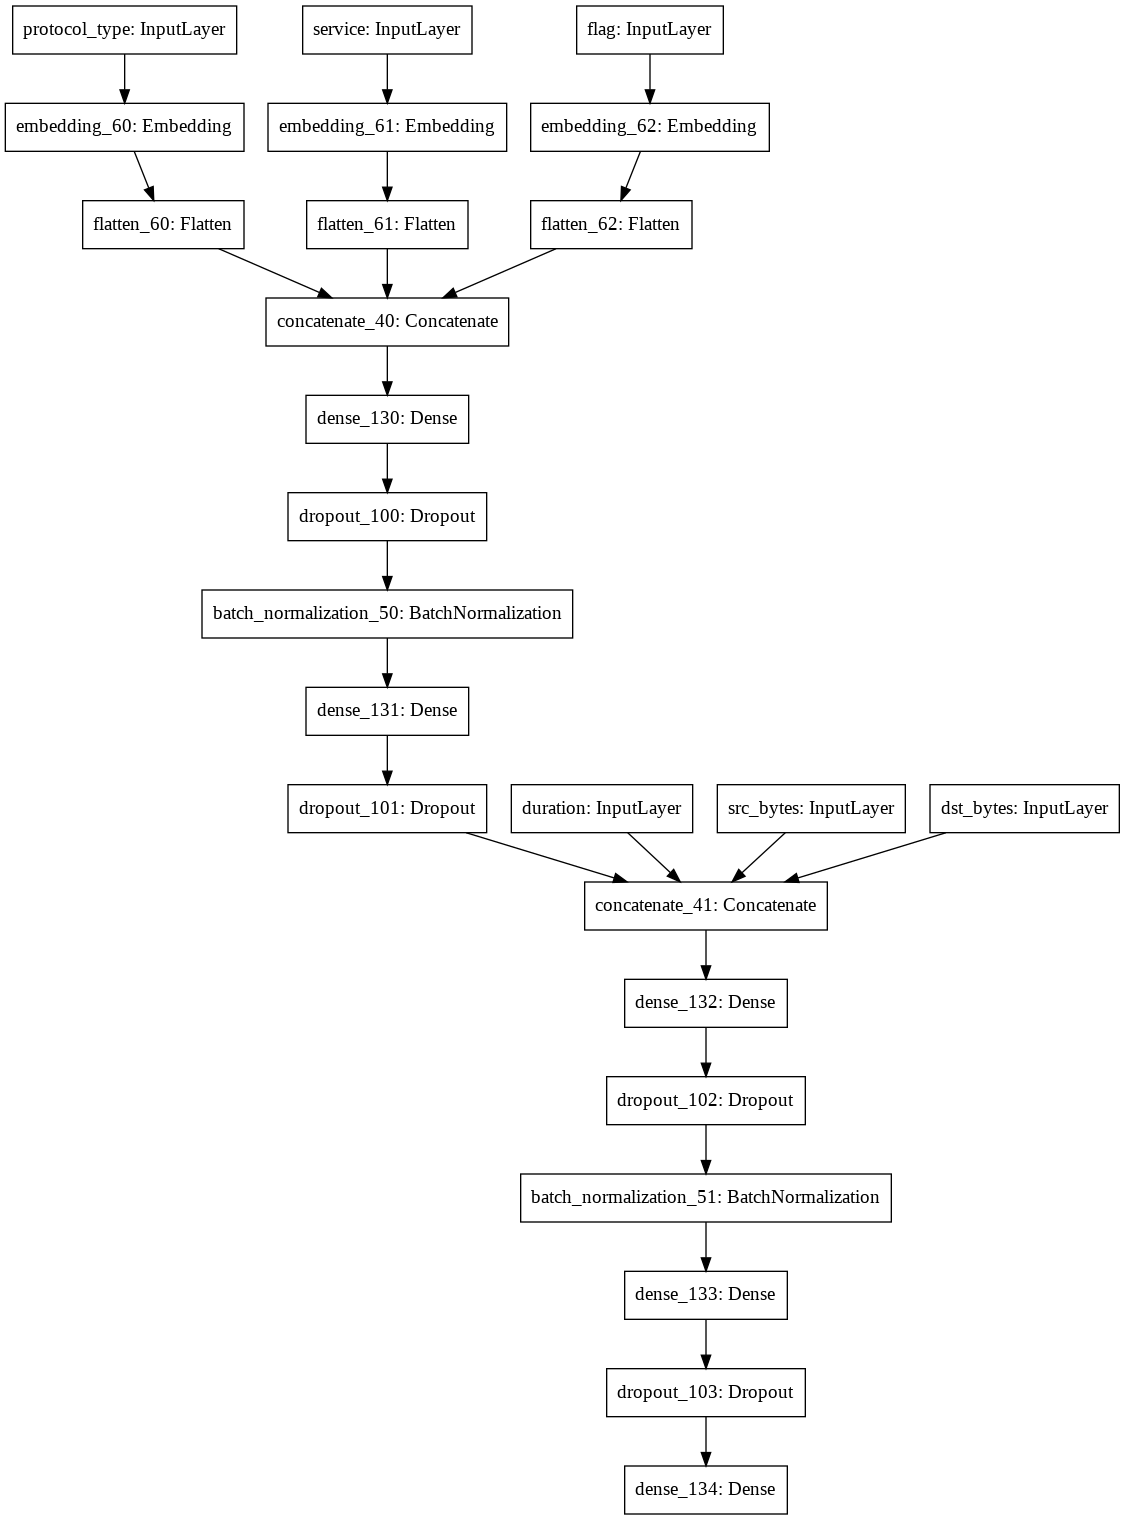

In [ ]:
from keras.utils import plot_model
plot_model(model_nn_emb_ls, to_file='model.png')

In [ ]:
print(np.mean(emb_ls_result))
print(np.mean(emb_result))
print(np.mean(onehot_result))

0.8010630189577091
0.7935138099712469
0.7890294507869807


In [ ]:
print(np.mean(emb_ls_result_p))
print(np.mean(emb_result_p))
print(np.mean(onehot_result_p))

0.6988069598730446
0.6871882793017456
0.6621868623894808


In [ ]:
print(np.mean(emb_ls_result_r))
print(np.mean(emb_result_r))
print(np.mean(onehot_result_r))

0.9361216568538601
0.9328185128675082
0.9560313606252797


In [ ]:
print(np.mean(emb_ls_result_f))
print(np.mean(emb_result_f))
print(np.mean(onehot_result_f))

0.7997204993748143
0.7911382156501077
0.7812138946360182
